In [1]:
from google.colab import files
import os

In [2]:
!pip install kaggle --quiet



files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d debeshjha1/kvasirseg
!unzip kvasirseg.zip -d kvasirseg/



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
  0% 0.00/144M [00:00<?, ?B/s]
100% 144M/144M [00:00<00:00, 1.64GB/s]
Archive:  kvasirseg.zip
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/1911.07069.pdf  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0qkwl35piu0993l0dewei2.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0qoxqj9q6s0835b43399p4.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0qx73cjw570799j4n5cjze.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0roawvklrq0799vmjorwfv.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0rx1idathl0835detmsp84.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0s2a9ekvms080138tjjpxr.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images/cju0s690hkp960855tjuaqvv0.jpg  
  inflating: kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_i

## EDA

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader



from torch.utils.data import Dataset
import cv2
import os


In [4]:
print("Train images:", len(os.listdir("/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images")))
print("Train masks:", len(os.listdir("/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks")))

Train images: 1000
Train masks: 1000


In [5]:
data_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")


In [6]:
sizes = []
for img_name in os.listdir(image_dir)[:100]:
    img = Image.open(os.path.join(image_dir, img_name))
    sizes.append(img.size)

unique_sizes = set(sizes)
print("Unique Size #:", len(unique_sizes))
print("Sample Sizes:", list(unique_sizes)[:5])

Unique Size #: 61
Sample Sizes: [(609, 528), (567, 528), (600, 528), (626, 547), (1224, 1012)]


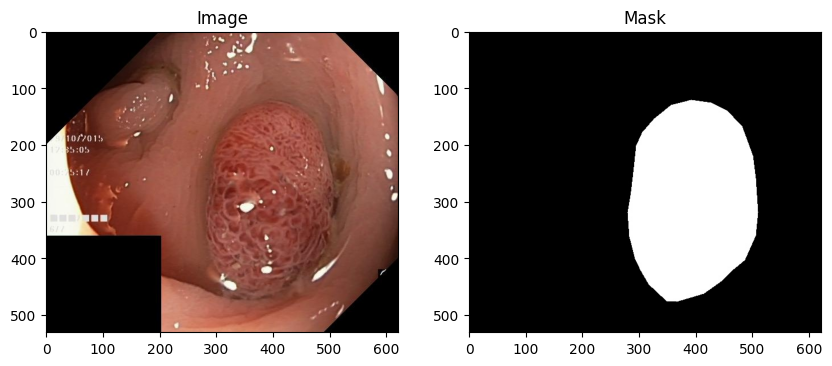

In [7]:
def show_example(idx=0):
    img_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    img = Image.open(os.path.join(image_dir, img_files[idx]))
    mask = Image.open(os.path.join(mask_dir, mask_files[idx]))

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask")
    plt.show()

show_example(112)

In [8]:
areas = []
for mask_name in os.listdir(mask_dir)[:200]:
    mask = np.array(Image.open(os.path.join(mask_dir, mask_name)).convert("L"))

    binary_mask = (mask > 128).astype(np.uint8) * 255
    polyp_pixel_count = np.sum(binary_mask > 0)
    total_pixels = binary_mask.size
    polyp_ratio = polyp_pixel_count / total_pixels
    areas.append(polyp_ratio)

print("Average Polyp Ratio: {:.2f}%".format(np.mean(areas)*100))
print("Max: {:.2f}%, Min: {:.2f}%".format(np.max(areas)*100, np.min(areas)*100))

Average Polyp Ratio: 14.67%
Max: 74.49%, Min: 0.88%


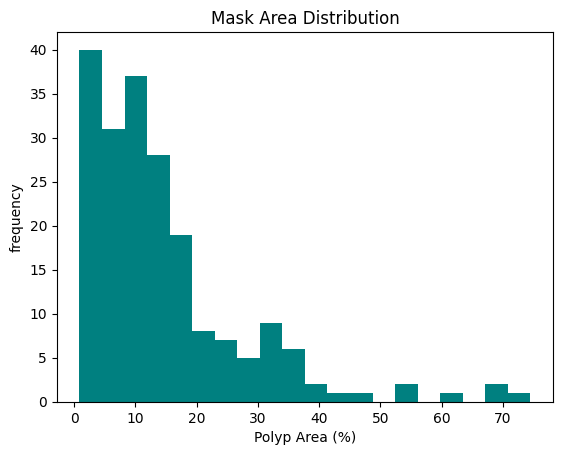

In [9]:
plt.hist(np.array(areas)*100, bins=20, color="teal")
plt.xlabel("Polyp Area (%)")
plt.ylabel("frequency")
plt.title("Mask Area Distribution")
plt.show()


##Preprocess

In [10]:
preprocess = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_LINEAR), # interpolation=cv2.INTER_LINEAR eklendi
    A.Normalize(mean=(0.0, 0.0, 0.0),
                std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

In [11]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])


        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        mask = (mask > 0).astype("float32")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.unsqueeze(0)

In [12]:
all_images = sorted(os.listdir(image_dir))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = PolypDataset(image_dir, mask_dir, transform=preprocess)
val_dataset   = PolypDataset(image_dir, mask_dir, transform=preprocess)


In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [14]:
images, masks = next(iter(train_loader))

print("Image tensor shape:", images.shape)
print("Mask tensor shape:", masks.shape)
print("Pixel range (image):", images.min().item(), "→", images.max().item())
print("Unique values (mask):", masks.unique())


Image tensor shape: torch.Size([8, 3, 256, 256])
Mask tensor shape: torch.Size([8, 1, 256, 256])
Pixel range (image): 0.0 → 1.0
Unique values (mask): tensor([0., 1.])


In [15]:
def plot_img(images, masks,i):
    img = images[i].permute(1,2,0).cpu().numpy()  # [C,H,W] → [H,W,C]
    mask = masks[i][0].cpu().numpy()              # [1,H,W] → [H,W]

    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(mask, cmap="gray",interpolation="nearest")
    axs[1].set_title("Mask")
    plt.show()

112. Görsel tensor boyutu: torch.Size([3, 256, 256])
112. Maske tensor boyutu: torch.Size([1, 256, 256])


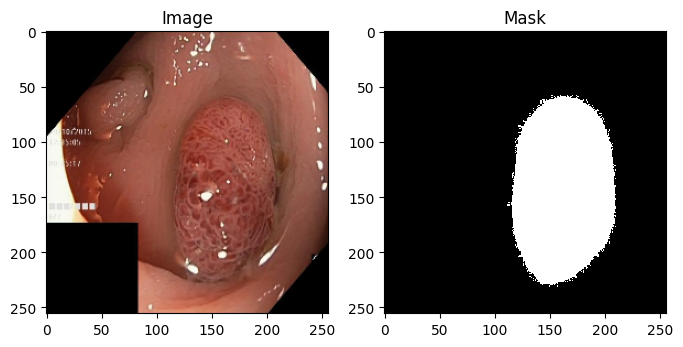

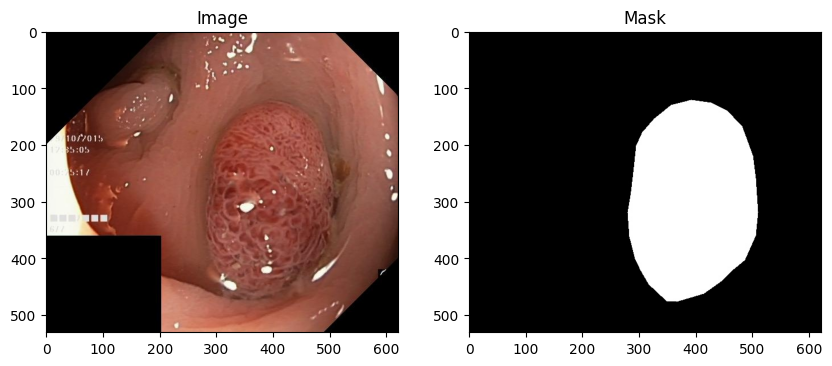

In [16]:
# 112. görseli (indeks 111) ve maskesini veri setinden al
image_112, mask_112 = train_dataset[112]

# Alınan verinin boyutlarını kontrol et
print("112. Görsel tensor boyutu:", image_112.shape)
print("112. Maske tensor boyutu:", mask_112.shape)

# plot_img fonksiyonunu kullanarak görselleştir
# plot_img fonksiyonu batch boyutu için tasarlanmış, bu yüzden tekil tensörleri batch boyutuna uygun hale getirmemiz gerekiyor
# Yani [C, H, W] -> [1, C, H, W] ve [1, H, W] -> [1, 1, H, W]
plot_img(image_112.unsqueeze(0), mask_112.unsqueeze(0), 0)

show_example(112)

## Augmentations


In [17]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05,
                       scale_limit=0.1,
                       rotate_limit=10, p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),
    ToTensorV2()
])


val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [18]:
train_dataset = PolypDataset(image_dir, mask_dir, transform=train_transform)
val_dataset   = PolypDataset(image_dir, mask_dir, transform=val_transform)


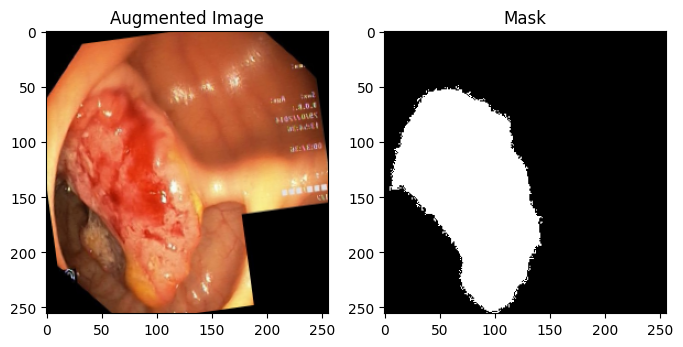

In [19]:
img, mask = train_dataset[12]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(img.permute(1,2,0).numpy())
axs[0].set_title("Augmented Image")
axs[1].imshow(mask[0].numpy(), cmap="gray")
axs[1].set_title("Mask")
plt.show()


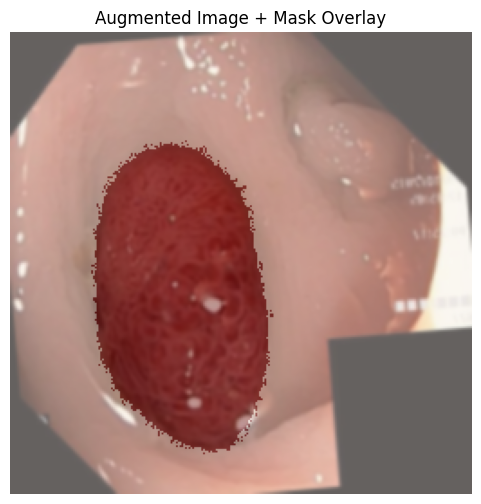

In [20]:
img, mask = train_dataset[112]   # (Tensor olarak geliyor)

# Tensor → numpy
img = img.permute(1,2,0).numpy()   # [C,H,W] → [H,W,C]
mask = mask[0].numpy()             # [1,H,W] → [H,W]

# plot
plt.figure(figsize=(6,6))
plt.imshow(img)                                 # arka plan: orijinal görüntü
plt.imshow(mask, cmap="Reds", alpha=0.4)        # kırmızı maske, %40 opaklık
plt.title("Augmented Image + Mask Overlay")
plt.axis("off")
plt.show()

In [21]:
!pip install segmentation-models-pytorch -q
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.1 MB/s eta 0:00:00


In [22]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchmetrics

In [23]:
model = smp.Unet(
    encoder_name="resnet34",        # backbone (ResNet34, pretrained on ImageNet)
    encoder_weights="imagenet",
    in_channels=3,                  # RGB input
    classes=1,                      # Binary segmentation
    activation=None                 # raw logits
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [24]:
bce = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

def loss_fn(y_pred, y_true):
    return 0.5 * bce(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [25]:
def dice_coef(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2. * intersection + eps) / (union + eps)
    return dice

def iou_coef(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    iou = (intersection + eps) / (union + eps)
    return iou


In [26]:
num_epochs = 20
from tqdm import tqdm

In [27]:
history = {
    "unet_resnet34": {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": [],
        "train_iou": [],
        "val_iou": []
    }
}

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss, train_dice, train_iou = 0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        # metrics
        train_loss += loss.item()
        train_dice += dice_coef(outputs, masks).item()
        train_iou  += iou_coef(outputs, masks).item()

        loop.set_postfix(loss=loss.item())

    # ortalamalar
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou  /= len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coef(outputs, masks).item()
            val_iou  += iou_coef(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou  /= len(val_loader)

    # history’ye ekle
    history["unet_resnet34"]["train_loss"].append(train_loss)
    history["unet_resnet34"]["val_loss"].append(val_loss)
    history["unet_resnet34"]["train_dice"].append(train_dice)
    history["unet_resnet34"]["val_dice"].append(val_dice)
    history["unet_resnet34"]["train_iou"].append(train_iou)
    history["unet_resnet34"]["val_iou"].append(val_iou)

    # epoch özeti
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Dice: {val_dice:.4f} "
          f"Val IoU: {val_iou:.4f}")

Epoch 1/20 [Train]: 100%|██████████| 125/125 [00:12<00:00, 10.19it/s, loss=0.304]


Epoch [1/20] Train Loss: 0.4066 Val Loss: 0.2422 Val Dice: 0.8525 Val IoU: 0.7455


Epoch 2/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.92it/s, loss=0.177]


Epoch [2/20] Train Loss: 0.2249 Val Loss: 0.1500 Val Dice: 0.9067 Val IoU: 0.8314


Epoch 3/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.89it/s, loss=0.0921]


Epoch [3/20] Train Loss: 0.1498 Val Loss: 0.1249 Val Dice: 0.9117 Val IoU: 0.8403


Epoch 4/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.85it/s, loss=0.158]


Epoch [4/20] Train Loss: 0.1224 Val Loss: 0.0871 Val Dice: 0.9359 Val IoU: 0.8807


Epoch 5/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s, loss=0.0704]


Epoch [5/20] Train Loss: 0.1053 Val Loss: 0.0896 Val Dice: 0.9297 Val IoU: 0.8697


Epoch 6/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.86it/s, loss=0.278]


Epoch [6/20] Train Loss: 0.0896 Val Loss: 0.0694 Val Dice: 0.9433 Val IoU: 0.8935


Epoch 7/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s, loss=0.168]


Epoch [7/20] Train Loss: 0.0769 Val Loss: 0.0771 Val Dice: 0.9349 Val IoU: 0.8793


Epoch 8/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.86it/s, loss=0.0627]


Epoch [8/20] Train Loss: 0.0666 Val Loss: 0.0538 Val Dice: 0.9552 Val IoU: 0.9145


Epoch 9/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.91it/s, loss=0.0847]


Epoch [9/20] Train Loss: 0.0608 Val Loss: 0.0564 Val Dice: 0.9530 Val IoU: 0.9106


Epoch 10/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s, loss=0.0541]


Epoch [10/20] Train Loss: 0.0559 Val Loss: 0.0453 Val Dice: 0.9615 Val IoU: 0.9260


Epoch 11/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.88it/s, loss=0.0531]


Epoch [11/20] Train Loss: 0.0453 Val Loss: 0.0394 Val Dice: 0.9656 Val IoU: 0.9336


Epoch 12/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.83it/s, loss=0.057]


Epoch [12/20] Train Loss: 0.0411 Val Loss: 0.0352 Val Dice: 0.9687 Val IoU: 0.9394


Epoch 13/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.86it/s, loss=0.035]


Epoch [13/20] Train Loss: 0.0375 Val Loss: 0.0330 Val Dice: 0.9702 Val IoU: 0.9423


Epoch 14/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.91it/s, loss=0.0366]


Epoch [14/20] Train Loss: 0.0346 Val Loss: 0.0326 Val Dice: 0.9705 Val IoU: 0.9428


Epoch 15/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s, loss=0.0412]


Epoch [15/20] Train Loss: 0.0331 Val Loss: 0.0307 Val Dice: 0.9720 Val IoU: 0.9456


Epoch 16/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.95it/s, loss=0.0402]


Epoch [16/20] Train Loss: 0.0314 Val Loss: 0.0284 Val Dice: 0.9736 Val IoU: 0.9486


Epoch 17/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.81it/s, loss=0.03]


Epoch [17/20] Train Loss: 0.0301 Val Loss: 0.0275 Val Dice: 0.9741 Val IoU: 0.9497


Epoch 18/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.85it/s, loss=0.0294]


Epoch [18/20] Train Loss: 0.0285 Val Loss: 0.0259 Val Dice: 0.9757 Val IoU: 0.9526


Epoch 19/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.78it/s, loss=0.0359]


Epoch [19/20] Train Loss: 0.0276 Val Loss: 0.0253 Val Dice: 0.9758 Val IoU: 0.9528


Epoch 20/20 [Train]: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s, loss=0.0415]


Epoch [20/20] Train Loss: 0.0317 Val Loss: 0.0363 Val Dice: 0.9661 Val IoU: 0.9348


## Results And Evaluation of smp resnet+unet

In [32]:
def summarize_results(history, model_name):
    data = history[model_name]

    best_dice = max(data["val_dice"])
    best_iou  = max(data["val_iou"])
    last_dice = data["val_dice"][-1]
    last_iou  = data["val_iou"][-1]

    print(f"Model: {model_name}")
    print(f"Best Val Dice: {best_dice:.4f}")
    print(f"Best Val IoU:  {best_iou:.4f}")
    print(f"Last Val Dice: {last_dice:.4f}")
    print(f"Last Val IoU:  {last_iou:.4f}")


In [33]:
summarize_results(history, "unet_resnet34")


Model: unet_resnet34
Best Val Dice: 0.9758
Best Val IoU:  0.9528
Last Val Dice: 0.9661
Last Val IoU:  0.9348


In [28]:
def visualize_predictions(model, dataloader, device, num_samples=4, threshold=0.5):
    model.eval()
    images, masks = next(iter(dataloader))  # bir batch al
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > threshold).float()

    images = images.cpu().permute(0,2,3,1).numpy()  # [B, H, W, C]
    masks = masks.cpu().numpy()                     # [B, 1, H, W]
    preds = preds.cpu().numpy()                     # [B, 1, H, W]

    # sadece ilk num_samples kadar örnek göster
    for i in range(min(num_samples, len(images))):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(images[i])
        axs[0].set_title("Input Image")
        axs[0].axis("off")

        axs[1].imshow(masks[i][0], cmap="gray")
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

        axs[2].imshow(preds[i][0], cmap="gray")
        axs[2].set_title("Predicted Mask")
        axs[2].axis("off")

        plt.show()

In [29]:
def plot_history(history, model_name):
    data = history[model_name]
    epochs = range(1, len(data["train_loss"]) + 1)

    plt.figure(figsize=(15,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, data["train_loss"], label="Train Loss")
    plt.plot(epochs, data["val_loss"], label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # IoU
    plt.subplot(1,3,2)
    plt.plot(epochs, data["train_iou"], label="Train IoU")
    plt.plot(epochs, data["val_iou"], label="Val IoU")
    plt.title(f"{model_name} - IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    # Dice
    plt.subplot(1,3,3)
    plt.plot(epochs, data["train_dice"], label="Train Dice")
    plt.plot(epochs, data["val_dice"], label="Val Dice")
    plt.title(f"{model_name} - Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.legend()

    plt.show()

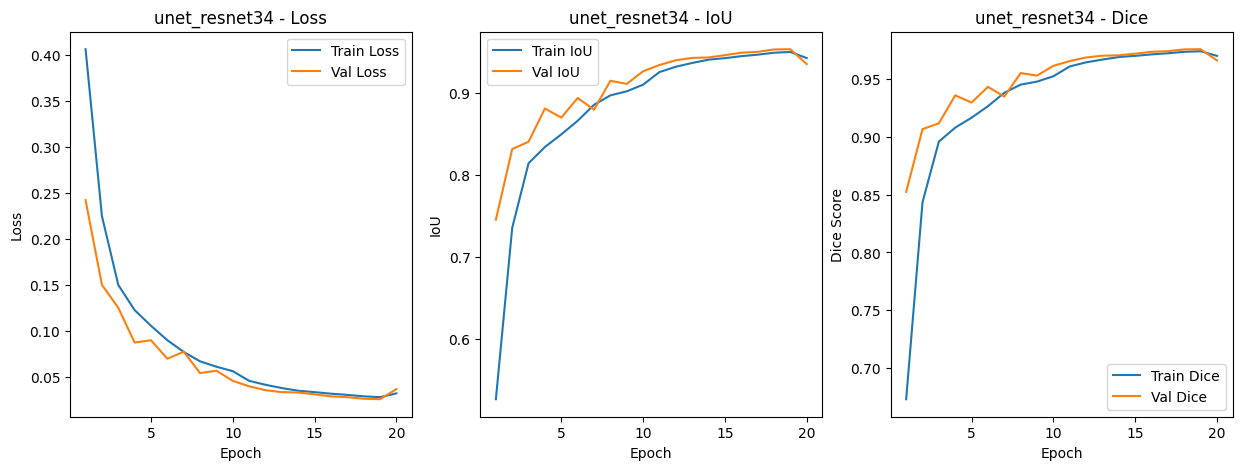

In [30]:
plot_history(history, "unet_resnet34")


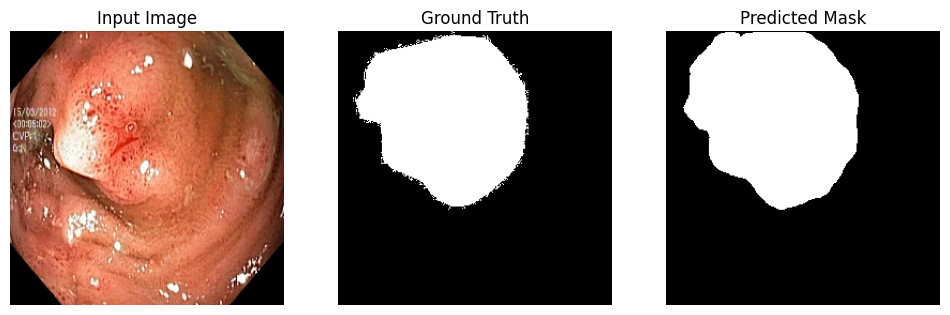

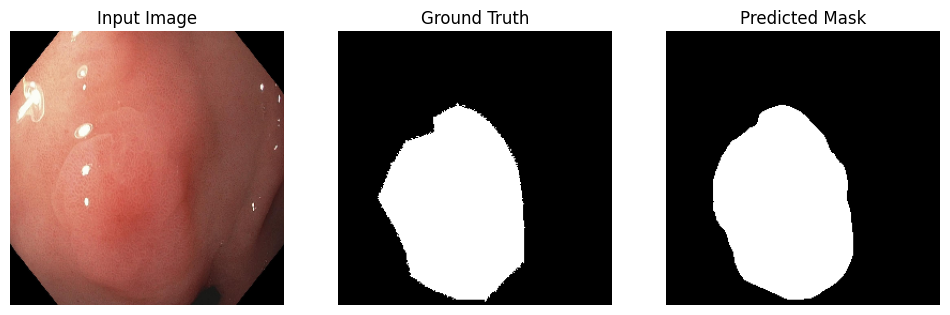

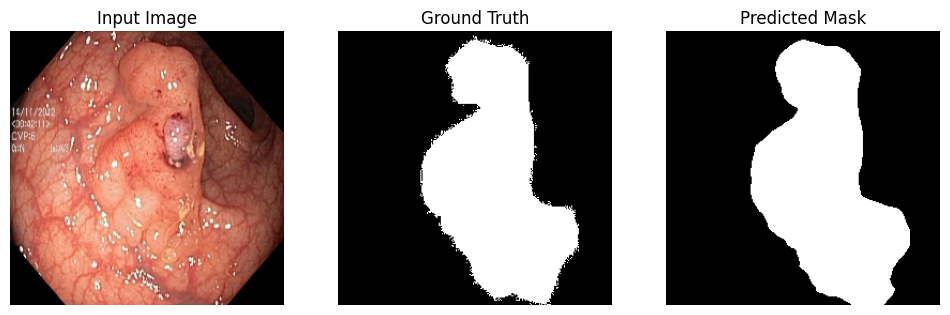

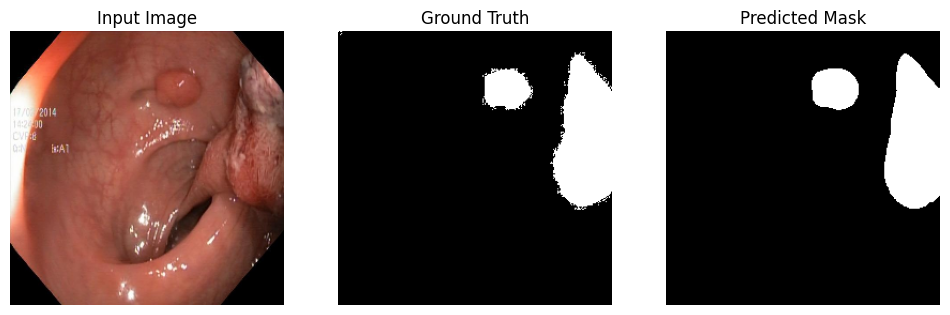

In [31]:
visualize_predictions(model, val_loader, device, num_samples=4)